# Problem Set 2.2

## John Wilson

### Problem 1

We show that *U* is a contraction mapping over the set $\mathcal{C}$. Take $\sigma$ and y as given. For any two functions $w, w' \in \mathcal{C}$, we have:
$$
\left| Uw(y) - Uw'(y) \right| = \\ \left| u(\sigma (y)) + \beta \int w(f(y-\sigma (y))z)\phi (dz) - u(\sigma (y)) - \beta \int w'(f(y-\sigma (y))z)\phi (dz)\right| = \\ \beta \left| \int (w(f(y-\sigma (y))z)-w'(f(y-\sigma (y))z))\phi (dz) \right| \leq \\ \beta \int \left| w(f(y-\sigma (y))z)-w'(f(y-\sigma (y))z) \right| \phi (dz) \leq \\ \beta \|w-w'\|_{sup} \int \phi dz = \beta \rho (w-w')
$$
Taking the supremum of the initial absolute value preserves the inequality relations and shows that $\rho (Uw(y),Uw'(y)) \leq \beta \rho(w,w')$. Since $\beta < 1$, this proves that *U* is a contraction mapping. Since $\mathcal{C}$ is complete with respect to the sup distance metric, *U* has a unique fixed point in $\mathcal{C}$.

To show that this unique fixed point is equal to $\mathcal{v}_{\sigma}$, observe first the definition of a fixed point. We have $$Uw^*(y)=w^*(y)=u(\sigma (y)) + \beta \int w^*(f(y-\sigma (y))z)\phi(dz)$$ This function is equal to the utility you get from immediate consumption plus the discounted expected utility you will get from all future consumption, all given the policy $\sigma (y)$. This is equivalent to the definition of the policy value function $v_{\sigma}$, defined as $$v_{\sigma}(y) = \mathbf{E} \left[ \sum_{t=0}^{\infty} \beta^tu(\sigma (y_t)) \right] $$
which is to say the expected utility of this period plus the discounted utility of all future consumption.

### Problem 2

Code below is a small alteration of the code provided at https://lectures.quantecon.org/py/optgrowth.html.

We alter the code to calculate the policy value function given that $\sigma (y) =0.95y$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from scipy.stats import lognorm
from scipy.optimize import fminbound

In [2]:
def bellman_operator(w, grid, beta, u, f, shocks, Tw=None, compute_policy=0):
    """
    The approximate Bellman operator, which computes and returns the
    updated value function Tw on the grid points.  An array to store
    the new set of values Tw is optionally supplied (to avoid having to
    allocate new arrays at each iteration).  If supplied, any existing data in 
    Tw will be overwritten.

    Parameters
    ----------
    w : array_like(float, ndim=1)
        The value of the input function on different grid points
    grid : array_like(float, ndim=1)
        The set of grid points
    beta : scalar
        The discount factor
    u : function
        The utility function
    f : function
        The production function
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).
    Tw : array_like(float, ndim=1) optional (default=None)
        Array to write output values to
    compute_policy : Boolean, optional (default=False)
        Whether or not to compute policy function

    """
    # === Apply linear interpolation to w === #
    w_func = lambda x: np.interp(x, grid, w)

    # == Initialize Tw if necessary == #
    if Tw is None:
        Tw = np.empty_like(w)

    if compute_policy:
        sigma = np.empty_like(w)

    # == set Tw[i] = max_c { u(c) + beta E w(f(y  - c) z)} == #
    for i, y in enumerate(grid):
        def objective(c):
            return - u(c) - beta * np.mean(w_func(f(y - c) * shocks))
        c_star = 0.95*y   #we are provided an optimal c given y
        if compute_policy:
            sigma[i] = c_star
        Tw[i] = - objective(c_star)

    if compute_policy:
        return Tw, sigma
    else:
        return Tw

In [3]:
class LogLinearOG:
    """
    Log linear optimal growth model, with log utility, CD production and
    multiplicative lognormal shock, so that

        y = f(k, z) = z k^alpha

    with z ~ LN(mu, s).

    The class holds parameters and true value and policy functions.
    """

    def __init__(self, alpha=0.4, beta=0.96, mu=0, s=0.1):

        self.alpha, self.beta, self.mu, self.s = alpha, beta, mu, s 

        # == Some useful constants == #
        self.ab = alpha * beta
        self.c1 = np.log(1 - self.ab) / (1 - beta)
        self.c2 = (mu + alpha * np.log(self.ab)) / (1 - alpha)
        self.c3 = 1 / (1 - beta)
        self.c4 = 1 / (1 - self.ab)

    def u(self, c):
        " Utility "
        return np.log(c)

    def u_prime(self, c):
        return 1 / c

    def f(self, k):
        " Deterministic part of production function.  "
        return k**self.alpha

    def f_prime(self, k):
        return self.alpha * k**(self.alpha - 1)

    def c_star(self, y):
        " True optimal policy.  "
        return (1 - self.alpha * self.beta) * y

    def v_star(self, y):
        " True value function. "
        return self.c1 + self.c2 * (self.c3 - self.c4) + self.c4 * np.log(y)

In [4]:
lg = LogLinearOG()
# == Unpack parameters / functions for convenience == #
alpha, beta, mu, s = lg.alpha, lg.beta, lg.mu, lg.s
v_star = lg.v_star

In [5]:
grid_max = 4         # Largest grid point
grid_size = 200      # Number of grid points
shock_size = 250     # Number of shock draws in Monte Carlo integral

grid = np.linspace(1e-5, grid_max, grid_size)
shocks = np.exp(mu + s * np.random.randn(shock_size))

Having set up the background work for the model, fixed points of *U* are calculated for a range of values of y.

In [6]:
from quantecon import compute_fixed_point

Tw = np.empty(len(grid))
initial_w = 5 * np.log(grid)

# Turn the Bellman operator into a function of one variable
T = lambda w: bellman_operator(w,
                               grid,
                               beta,
                               np.log,
                               lambda k: k**alpha,
                               shocks,
                               compute_policy=False)

v_star_approx = compute_fixed_point(T, initial_w,
                                    error_tol=1e-5,  # error_tol
                                    max_iter=500,   # max_iter
                                    verbose=2,  # verbose
                                    print_skip=10,     # print_skip
                                    method='iteration')

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
10           1.282e+00      5.204e-02         
20           7.812e-01      9.907e-02         
30           5.100e-01      1.446e-01         
40           3.378e-01      1.907e-01         
50           2.244e-01      2.492e-01         
60           1.492e-01      2.952e-01         
70           9.919e-02      3.413e-01         
80           6.594e-02      3.868e-01         
90           4.384e-02      4.318e-01         
100          2.915e-02      4.828e-01         
110          1.938e-02      5.309e-01         
120          1.288e-02      5.764e-01         
130          8.565e-03      6.220e-01         
140          5.694e-03      6.700e-01         
150          3.786e-03      7.245e-01         
160          2.517e-03      7.705e-01         
170          1.673e-03      8.156e-01         
180          1.112e-03      8.606e-01         
190          7.396e-04      9.051e-01         
200          4.

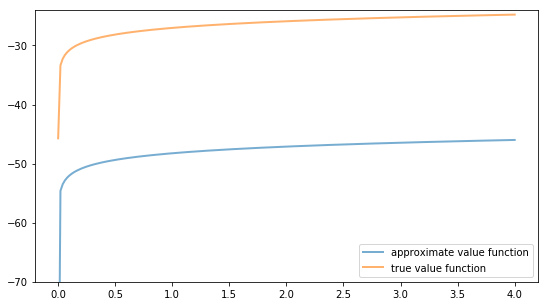

In [7]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(-70, -24)
ax.plot(grid, v_star_approx, lw=2, alpha=0.6, label='approximate value function')
ax.plot(grid, v_star(grid), lw=2, alpha=0.6, label='true value function')
ax.legend(loc='lower right')
plt.show()

Given the log utility model, which can be solved analytically, the yellow line shows the true value function, meaning the value function for the best policy $\sigma (y)$ to maximize utility. Since we were given an alternate $\sigma$ function, we can see that the calculated value function is much lower than the desired value function. We now proceed to redo the process with $\sigma (y) = H(y)y$, where *H* is the cdf of the lognormal *LN(0,0.5)* distribution.

In [8]:
def bellman_operator(w, grid, beta, u, f, shocks, Tw=None, compute_policy=0):
    """
    The approximate Bellman operator, which computes and returns the
    updated value function Tw on the grid points.  An array to store
    the new set of values Tw is optionally supplied (to avoid having to
    allocate new arrays at each iteration).  If supplied, any existing data in 
    Tw will be overwritten.

    Parameters
    ----------
    w : array_like(float, ndim=1)
        The value of the input function on different grid points
    grid : array_like(float, ndim=1)
        The set of grid points
    beta : scalar
        The discount factor
    u : function
        The utility function
    f : function
        The production function
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).
    Tw : array_like(float, ndim=1) optional (default=None)
        Array to write output values to
    compute_policy : Boolean, optional (default=False)
        Whether or not to compute policy function

    """
    # === Apply linear interpolation to w === #
    w_func = lambda x: np.interp(x, grid, w)

    # == Initialize Tw if necessary == #
    if Tw is None:
        Tw = np.empty_like(w)

    if compute_policy:
        sigma = np.empty_like(w)

    # == set Tw[i] = max_c { u(c) + beta E w(f(y  - c) z)} == #
    for i, y in enumerate(grid):
        def objective(c):
            return - u(c) - beta * np.mean(w_func(f(y - c) * shocks))
        c_star = lognorm.cdf(y, 0.5)*y   #fminbound(objective, 1e-10, y)
        if compute_policy:
            sigma[i] = c_star
        Tw[i] = - objective(c_star)

    if compute_policy:
        return Tw, sigma
    else:
        return Tw

In [9]:
from quantecon import compute_fixed_point

Tw = np.empty(len(grid))
initial_w = 5 * np.log(grid)

# Turn the Bellman operator into a function of one variable
T = lambda w: bellman_operator(w,
                               grid,
                               beta,
                               np.log,
                               lambda k: k**alpha,
                               shocks,
                               compute_policy=False)

v_star_approx = compute_fixed_point(T, initial_w,
                                    error_tol=1e-5,  # error_tol
                                    max_iter=500,   # max_iter
                                    verbose=2,  # verbose
                                    print_skip=10,     # print_skip
                                    method='iteration')

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
10           1.387e+00      2.847e-01         
20           6.516e-01      5.313e-01         
30           4.330e-01      7.760e-01         
40           2.879e-01      1.020e+00         
50           1.914e-01      1.264e+00         
60           1.272e-01      1.508e+00         
70           8.459e-02      1.752e+00         
80           5.624e-02      1.998e+00         
90           3.739e-02      2.243e+00         
100          2.486e-02      2.486e+00         
110          1.653e-02      2.728e+00         
120          1.099e-02      2.972e+00         
130          7.305e-03      3.220e+00         
140          4.856e-03      3.466e+00         
150          3.229e-03      3.717e+00         
160          2.147e-03      3.958e+00         
170          1.427e-03      4.202e+00         
180          9.488e-04      4.452e+00         
190          6.308e-04      4.696e+00         
200          4.

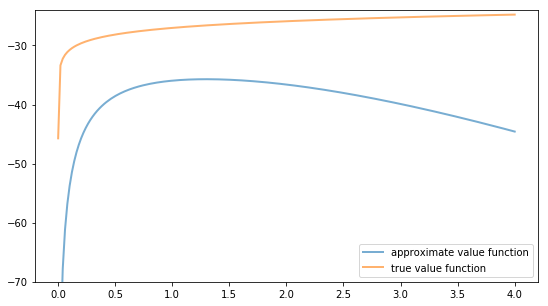

In [10]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(-70, -24)
ax.plot(grid, v_star_approx, lw=2, alpha=0.6, label='approximate value function')
ax.plot(grid, v_star(grid), lw=2, alpha=0.6, label='true value function')
ax.legend(loc='lower right')
plt.show()

This is clearly not the best policy since $v_{\sigma}$ is below $v^*$ for all values of y.